# MagicBox
The magic box is a cuboid object that can generate any force and torque.
* Run the scene magicbox.ttt in CoppeliaSim

In [169]:

%pylab inline
import sim

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [170]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'MagicBox'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print(name, 'is at [x,y,z]=', position)
    
    
    #res, position = sim.simxAddForce(clientID, name,[0,0,10],[0,0,0])
    

    res = sim.simxSetFloatSignal(clientID,'fx', 0.0,sim.simx_opmode_oneshot_wait)
    print(res)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  476454
MagicBox is at [x,y,z]= [111.56782531738281, -272.31036376953125, -960.1062622070312]
0
Disconnected


# Robot

In [171]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)                
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    # Added this, Was missing get orientation
    def get_orientation(self, relative_object=-1): 
        # Retrieves the orientation (Euler angles) of an object.
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, orientation = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(orientation)
    
    def get_velocity(self, relative_object=-1):
        # Get velocity relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, velocity, omega = sim.simxGetObjectVelocity(self.client_id, self.frame, sim.simx_opmode_blocking)        
        return array(velocity), array(omega)

    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def set_signal(self, signal, value):
        return sim.simxSetFloatSignal(clientID, signal, value, sim.simx_opmode_oneshot_wait)
        
    def wrench(self, w):
        names = ['fx', 'fy', 'fz', 'Mx', 'My', 'Mz']
        for ni, wi in zip(names, w):
            self.set_signal(ni, wi)
        

In [172]:
# Send force to a robot
r = robot('MagicBox')  # Create an instance of our robot
r.wrench([0,0,0,0,0,0])

r.close_connection()  

Robot connected
Connection closed


# PD-Control

In [173]:
# Rotation Euler Angles Tait-Bryan convention - https://coppeliarobotics.com/helpFiles/en/eulerAngles.htm
import numpy as np

# Rotation around Z-axis 
def yaw_rotateX(w):
    yaw = np.array([[1, 0, 0], [0 , np.cos(w),  - np.sin(w)], [0, np.sin(w), np.cos(w)]])  
    return yaw


# Rotation around Y-axis 
def pitch_rotateY(v):
    pitch = np.array([[np.cos(v), 0 , np.sin(v)], [0, 1, 0], [-np.sin(v), 0, np.cos(v)]])   
    return pitch


# Rotation around z-axis 
def roll_rotateZ(u):
    roll = np.array([ [np.cos(u), - np.sin(u), 0], [np.sin(u), np.cos(u), 0], [0, 0, 1]])  
    return roll

    

In [ ]:
import math
# Send force to a robot
r = robot('MagicBox')  # Create an instance of our robot
d = robot('DesiredBox')

m = 8 #kg mass of the block plus the mass of the prop
g = 9.81
I = 80

log = []
print("r position:", r.get_position())
print("d position:", d.get_position())

print("r orientation:", r.get_orientation())

try:

    while True:
        # Robot state
        p = r.get_position()
        v, ω = r.get_velocity()
        theta = r.get_orientation()

        # Desired state
        p_d = d.get_position() + [0, 0, 2] # Because we want it to be flying, in the air 
        v_d, ω_d = d.get_velocity()
        theta_d = d.get_orientation() + [0, 0, np.pi/6]


        ep = p_d - p
        ev = v_d - v
        eω = ω_d - ω
        # error in orientation
        et = theta_d - theta 


        kp, kd = 0.01, 0.25
        a = kp * ep + kd * ev

        # angular acceleration
        kp_th , kd_th = 0.004, 0.02 
        ath = kp_th * et + kd_th * eω 
        torq = I * ath 


        f = m * a
        f[2] += m*g

       # https://help.naturalpoint.com/kb/articles/transform-world-space-coordinates-to-local-rigid-body-coordinates
        R =  yaw_rotateX( theta_d[0])  * pitch_rotateY(theta_d[1]) * roll_rotateZ( theta_d[2] )
        f_d = np.dot(R, f)
        r.wrench( [f_d[0], f_d[1], f_d[2], torq[0], torq[1], torq[2]]  )
        
        log.append(ep)
        time.sleep(0.001)
except KeyboardInterrupt:
    r.close_connection()
    
   

    # Homework 6:
    # 1- Change the force from world frame to body frame
    # 2- Get the rotation matrix from world to body/magic box frame. Note: you can use euler angles instead of rotation matrices
    # 3- Get the rotation matrix from world to body/desired box frame
    # 4- Compute the error in orientation
    # 5- PD controller -> angular acceleration
    # 6- Compute torques
    # 7- send the wrench
    
    # TODO: when we send wrench it is in the body frame now ? 
    # TODO: do I need to call/write a different wrench function
    
    # r.wrench([f[0], f[1], f[2], 0,0,0])

    # r.wrench( [f_d[0], f_d[1], f_d[2], torq[0], torq[1], torq[2]]  )
    
    # r.wrench([f[0], f[1], f[2], 0,0,0])
    
    

Robot connected
Robot connected
r position: [-3.64652942e-06  2.17497090e-10  9.99999195e-02]
d position: [ 0.02499989 -0.37500006  0.29999986]
r orientation: [-1.99208694e-09 -4.55175675e-09 -8.92465829e-14]


In [ ]:
r.close_connection()
d.close_connection()

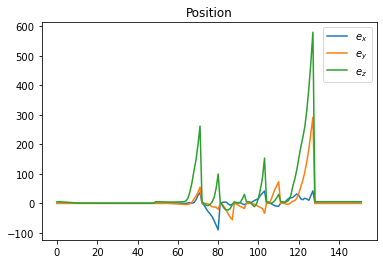

In [111]:
log = array(log)
plot(log[:,0], label='$e_x$')
plot(log[:,1], label='$e_y$')
plot(log[:,2], label='$e_z$')
title('Position')
legend()